In [7]:
import os

os.environ["HTTP_PROXY"] = "http://127.0.0.1:10808"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:10808"

In [ ]:
import json
import pandas as pd

import torch
from torch.optim import AdamW
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

## Load Data

In [ ]:
# # Define the directory
# tsv_dir = '../Article-Bias-Prediction/data/splits/media'
# json_dir = '../Article-Bias-Prediction/data/jsons'

# tsv_files = [f for f in os.listdir(tsv_dir) if f.endswith('.tsv')]

# data_list = []

# for tsv in tsv_files:
#     tsv_path = os.path.join(tsv_dir, tsv)
#     try:
#         df = pd.read_csv(tsv_path, sep='\t')
#         print(f"Successfully read {tsv}")
#     except Exception as e:
#         print(f"Error reading {tsv}: {e}")
    
#     for row in df.itertuples():
#         file_path = os.path.join(json_dir, f"{row.ID}.json")
#         try:
#             with open(file_path, 'r', encoding='utf-8') as f:
#                 data = json.load(f)
#                 data["split"] = tsv.split('.')[0]
#                 data_list.append(data)  # Append JSON data to the list
#         except json.JSONDecodeError:
#             print(f"Error: {file_path} contains invalid JSON!")
#         except Exception as e:
#             print(f"Error reading {file_path}: {e}")
        

# df = pd.DataFrame(data_list)
# df.to_csv('data_media_split.csv', index=False)

Successfully read test.tsv
Successfully read train.tsv


Successfully read valid.tsv


In [4]:
df = pd.read_csv("../data/data_random_split.csv")

In [ ]:
df_test = df[df["split"] == "test"].copy()
df_test

In [25]:
df_test

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,test
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,test
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,test
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,test


<Axes: title={'center': 'Content Length'}, ylabel='Frequency'>

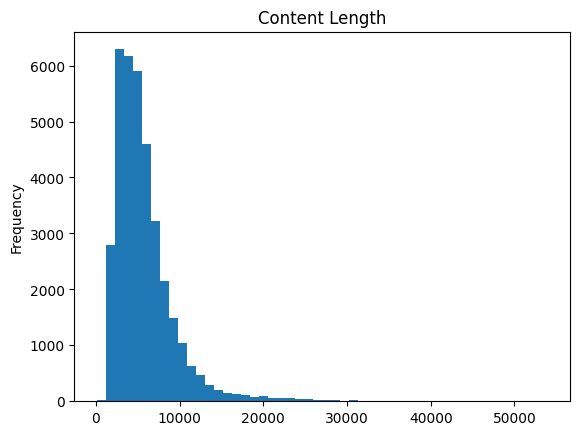

In [4]:
# Plot content length
df['content_length'] = df['content'].apply(len)
df['content_length'].plot.hist(bins=50, title="Content Length")

<Axes: title={'center': 'Size of split=train,val,test'}, xlabel='split'>

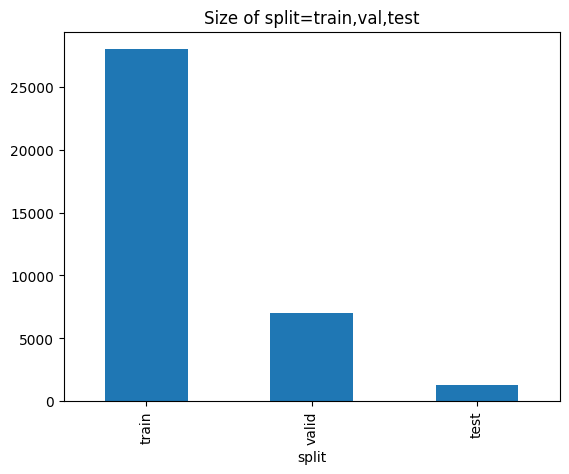

In [5]:
# Plot size of split=train,val,test

df['split'].value_counts().plot(kind='bar', title="Size of split=train,val,test")

<Axes: title={'center': 'Year Distribution'}, ylabel='Frequency'>

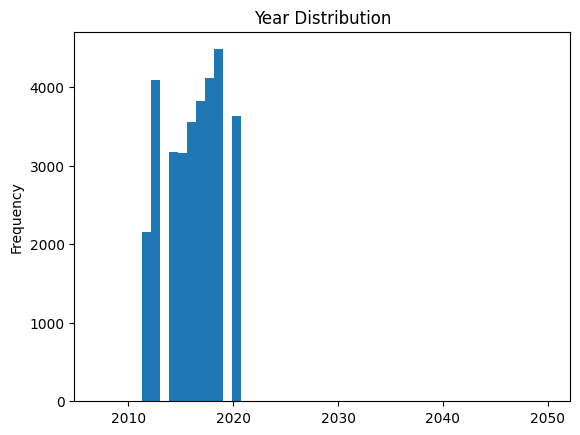

In [28]:
# Plot the year distribution
year_df = df.dropna(subset=['date'])
year_df = year_df[year_df["date"].str.contains("-")]
year_df['year'] = year_df['date'].apply(lambda x: int(x.split('-')[0]))
year_df['year'].plot.hist(bins=50, title="Year Distribution")

## Existing Roberta nodel

In [11]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

repository = "premsa/political-bias-prediction-allsides-BERT"
model = AutoModelForSequenceClassification.from_pretrained(repository)
tokenizer = AutoTokenizer.from_pretrained(repository)
roberta = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    max_length=512,
)


Device set to use cuda:0


In [14]:
labels = roberta(df_test["content"].tolist())
labels

[{'label': 'LABEL_2', 'score': 0.7073867321014404},
 {'label': 'LABEL_0', 'score': 0.6330365538597107},
 {'label': 'LABEL_2', 'score': 0.5896987915039062},
 {'label': 'LABEL_2', 'score': 0.7187697291374207},
 {'label': 'LABEL_2', 'score': 0.9384896159172058},
 {'label': 'LABEL_1', 'score': 0.9642848372459412},
 {'label': 'LABEL_2', 'score': 0.6026054620742798},
 {'label': 'LABEL_0', 'score': 0.4852510094642639},
 {'label': 'LABEL_1', 'score': 0.9868680238723755},
 {'label': 'LABEL_0', 'score': 0.6888425350189209},
 {'label': 'LABEL_2', 'score': 0.8533273339271545},
 {'label': 'LABEL_2', 'score': 0.817845344543457},
 {'label': 'LABEL_2', 'score': 0.9450438618659973},
 {'label': 'LABEL_2', 'score': 0.897118330001831},
 {'label': 'LABEL_0', 'score': 0.4954582750797272},
 {'label': 'LABEL_0', 'score': 0.9706498980522156},
 {'label': 'LABEL_0', 'score': 0.8527403473854065},
 {'label': 'LABEL_0', 'score': 0.8620717525482178},
 {'label': 'LABEL_0', 'score': 0.5641849637031555},
 {'label': 'LA

In [15]:
for label in labels:
    label["label"] = int(label["label"][-1])

In [16]:
labels = pd.DataFrame(labels)
df_test = pd.concat([df_test, labels], axis=1)
df_test

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split,label,score
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test,2,0.707387
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test,0,0.633037
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test,2,0.589699
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test,2,0.718770
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test,2,0.938490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,test,2,0.947472
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,test,0,0.696791
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,test,0,0.853401
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,test,0,0.955279


In [18]:
# Classification report
from sklearn.metrics import classification_report

print(
    classification_report(
        df_test["bias"],
        df_test["label"],
        target_names=["left", "center", "right"],
    )
)

              precision    recall  f1-score   support

        left       0.49      0.84      0.62       402
      center       0.89      0.37      0.52       299
       right       0.79      0.65      0.71       599

    accuracy                           0.64      1300
   macro avg       0.72      0.62      0.62      1300
weighted avg       0.72      0.64      0.64      1300



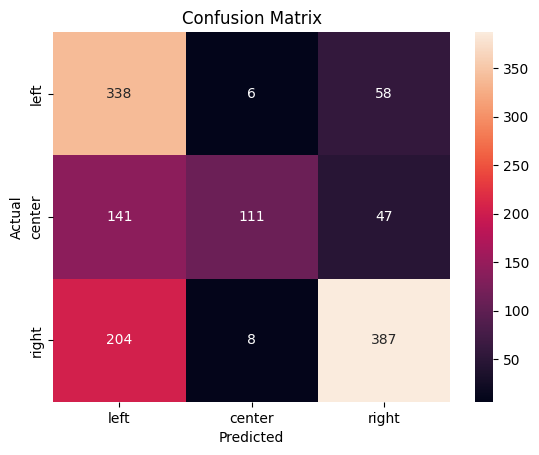

In [20]:
# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(df_test["bias"], df_test["label"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Existing Llama Model

In [30]:
# 1. Load the *base* LLaMA model for sequence classification
base_model_name = "meta-llama/Llama-3.2-1B"
tokenizer_name = "tokenizer"
access_token = os.environ.get("HF_TOKEN")

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    token=access_token,
    num_labels=3,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 2. Load the LoRA adapter on top of the base model
adapter_path = "tzoulio/news-bias-finder-llama-3.2-1B"
model = PeftModel.from_pretrained(model, adapter_path)

# 3. Create the pipeline with the specified model and tokenizer
pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer
)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64

Device set to use cuda:0
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 

In [ ]:
# Evaluate the model
labels = pipeline(df_test["content"].tolist())

In [32]:
for label in labels:
    label["label"] = int(label["label"][-1])

labels = pd.DataFrame(labels)
df_test = pd.concat([df_test, labels], axis=1)
df_test

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split,label,score
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test,2,0.999961
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test,0,0.936256
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test,1,1.000000
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test,2,1.000000
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test,2,0.999834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,test,2,0.999970
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,test,0,0.985097
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,test,2,0.998259
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,test,2,0.999900


In [33]:
# Classification report
print(
    classification_report(
        df_test["bias"],
        df_test["label"],
        target_names=["left", "center", "right"],
    )
)

              precision    recall  f1-score   support

        left       0.96      0.96      0.96       402
      center       0.95      0.99      0.97       299
       right       0.98      0.96      0.97       599

    accuracy                           0.97      1300
   macro avg       0.97      0.97      0.97      1300
weighted avg       0.97      0.97      0.97      1300



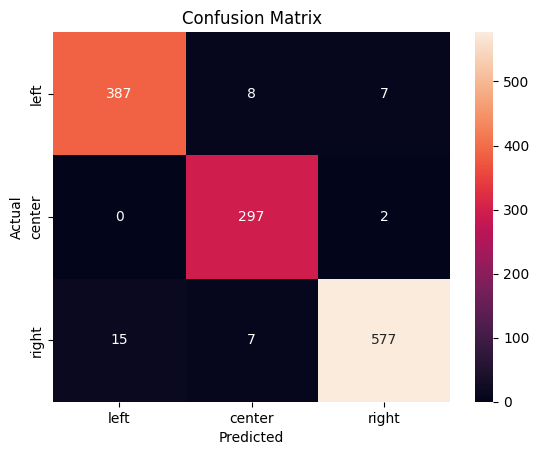

In [34]:
# Confusion matrix
cm = confusion_matrix(df_test["bias"], df_test["label"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Finetune Llama Model

In [29]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
df = pd.read_csv("data_random_split.csv")

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
) # setup bits and bytes config

# Load tokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, quantization_config=bnb_config, num_labels=3)

# Set pad token
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model) # prepares the whole model for kbit training

config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, config) # Now you get a model ready for QLoRA training

This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_re

In [6]:
# Label mapping
label_map = {"left": 0, "center": 1, "right": 2}

# Custom Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, data, label_map, tokenizer):
        self.data = data
        self.label_map = label_map
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]["content"]
        label = self.data.iloc[idx]["bias"]  # Map label correctly
        return {"text": text, "label": label}

# Dynamic Padding in DataLoader
def collate_fn(batch):
    texts = [item["text"] for item in batch]
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

    # Apply dynamic padding
    tokenized = tokenizer(
        texts,
        padding=True,  # Enable dynamic padding
        truncation=True,
        return_tensors="pt"
    )

    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": labels
    }
    
train_dataset = TextClassificationDataset(df[df["split"] == "train"], label_map, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)

val_dataset = TextClassificationDataset(df[df["split"] == "valid"], label_map, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)

# Test the DataLoader
batch = next(iter(train_dataloader))
print(batch)


{'input_ids': tensor([[128000,  13622,  35748,  ..., 128256, 128256, 128256],
        [128000,    791,  56527,  ..., 128256, 128256, 128256],
        [128000,  12487,   7424,  ...,    279,  26969,    662],
        [128000,  48414,   5513,  ..., 128256, 128256, 128256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 2, 2, 1])}


In [ ]:
from accelerate import Accelerator

# Initialize accelerator
accelerator = Accelerator()
device = accelerator.device

# Wrap model & optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

num_epochs = 3
log_steps = 10  # Log loss every `n` steps

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Move batch to the correct device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        accelerator.backward(loss)
        optimizer.step()

        total_loss += loss.item()

        if (step + 1) % log_steps == 0:
            print(f"Epoch {epoch + 1}, Step {step + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

print("Training complete!")


In [ ]:
text = ["Government policies should be more inclusive."]
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Get predictions
outputs = model(**inputs)
outputs

## Finetuned Llama Evaluation

In [35]:
# 1. Load the *base* LLaMA model for sequence classification
base_model_name = "meta-llama/Llama-3.2-1B"
tokenizer_name = "tokenizer"
access_token = os.environ.get("HF_TOKEN")

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    token=access_token,
    num_labels=3,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Set pad token
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

# 2. Load the LoRA adapter on top of the base model
adapter_path = "best_model"
model = PeftModel.from_pretrained(model, adapter_path)

# 3. Create the pipeline with the specified model and tokenizer
pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer
)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Device set to use cuda:0
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSeq

In [40]:
df_test = df[df["split"] == "test"].copy()

In [36]:
# Evaluate the model
labels = pipeline(df_test["content"].tolist())

In [ ]:
for label in labels:
    label["label"] = int(label["label"][-1])

In [42]:
labels = pd.DataFrame(labels)
df_test = pd.concat([df_test, labels], axis=1)
df_test

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split,label,score
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test,2,0.995575
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test,0,0.586221
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test,1,0.999632
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test,2,0.999273
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test,2,0.994266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,test,2,0.983001
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,test,2,0.513564
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,test,1,0.858560
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,test,2,0.997306


In [43]:
# Classification report
print(
    classification_report(
        df_test["bias"],
        df_test["label"],
        target_names=["left", "center", "right"],
    )
)

              precision    recall  f1-score   support

        left       0.92      0.87      0.89       402
      center       0.84      0.96      0.89       299
       right       0.93      0.90      0.92       599

    accuracy                           0.90      1300
   macro avg       0.90      0.91      0.90      1300
weighted avg       0.91      0.90      0.90      1300



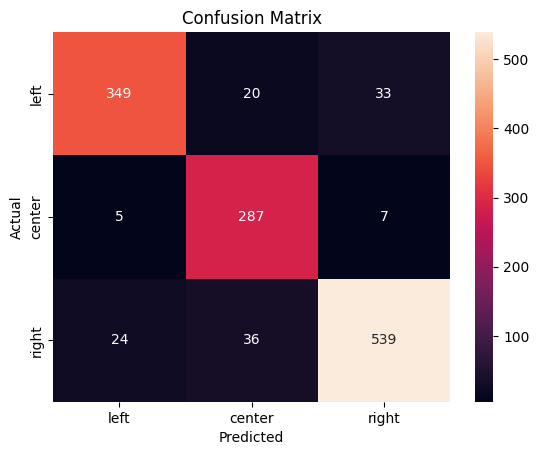

In [44]:
# Confusion matrix
cm = confusion_matrix(df_test["bias"], df_test["label"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()